# Tools

In [1]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import copy
from sklearn.cluster import KMeans
from tqdm import tqdm
from scipy.special import softmax


def gen_user_S(n=5, k=None, d=2,
               user_group_sizes=[10,3,2,2,1],
               centroid_distr='normal',
               action_type='continuous',
               user_cluster_radius=0.1,
               action_cluster_radius=0.1,
               normalization=False,
               stylized=False):
    """Generate user population and each player's action set
    Args:
        n: number of players
        k: size of action set
        d: dimension of action space
        normalization: if True, normalize user and action representation to the unit sphere
    Return:
        users: user population of size #(m, d),
        S: strategy set of size #(n, k, d) when action_type is discrete
           the initial strategy od size #(n, d) for each player when action_typeis continuous
    """

    if k is None:
        k = 5
    # sample cluster centroids
    num_cluster = len(user_group_sizes)
    if centroid_distr == 'normal':
        centroids = np.random.randn(num_cluster, d)
    else:
        centroids = np.random.rand(num_cluster, d)
    if normalization:
        centroids = normalize(centroids)

    if stylized:
        normalization = False
        n, k, d = 5, 5, 2
        user_group_sizes = [10, 3, 2, 2, 1]
        centroids = np.array([[0.,0],[0,1],[1,0],[-1,0],[0,-1]])
        num_cluster = len(user_group_sizes)

    # generate user population
    users = np.empty(shape=(0, d))
    for i in range(num_cluster):
      new_users = np.random.multivariate_normal(mean=centroids[i],
                                                cov=user_cluster_radius**2*np.eye(d),
                                                size=(user_group_sizes[i],))
      users = np.vstack([users, new_users])
    if normalization:
        users = normalize(users)

    # generate strategy set
    if not action_type.startswith('discrete'):
        if centroid_distr == 'normal':
            S = np.random.randn(n, d)
        else:
            S = np.random.rand(n, d)
        if normalization:
            S = normalize(S)
    else:
        if action_type == 'discrete_centroid':
            S = np.stack([centroids] * n)
        elif action_type == 'discrete_random':
            S = centroids[np.random.choice(num_cluster, n*k)]
            S += np.random.randn(n * k, d) * action_cluster_radius
            if normalization:
                S = normalize(S)
            S = S.reshape(n, k, d)

    return users, S, centroids

def gen_random_directions(n, d):
    return preprocessing.normalize(np.random.randn(n, d), norm='l2')

def pairwise_dist(M1, M2, metric='l2'):
    """ Compute the pairwise distances
    :param M1: (n, d）
    :param M2: (m, d)
    :return: (n, m)
    """
    n, d, m = M1.shape[0], M1.shape[1], M2.shape[0]
    assert M2.shape[1] == M1.shape[1]

    if metric == 'l2':
        return (np.sum(M1 ** 2, axis=1).reshape(n, 1).repeat(m, 1) + np.sum(M2 ** 2, axis=1).reshape(m, 1).repeat(
            n, 1).T - 2 * M1 @ M2.T) ** 0.5
    else:
        return M1 @ M2.T

def proj_sphere(target):
    n = target.shape[0]
    return target * np.ones((n, 1)) / np.linalg.norm(target, axis=1).reshape(n, 1)

def proj_target(targets, candidate_set, metric='l2'):
    """Finds l2/cosine-projection of targets in the candidate set."""
    # targets: [batch_size, embed_size]
    # candidate set: [total_num, embed_size]
    batch_size = np.shape(targets)[0]
    # diff_target: [total_mum, batch_size, embed_size]
    # score_diff_target: [total_num, batch_size]

    if metric == 'l2':
        diff_target = np.tile(candidate_set[:, None, :],
                              [1, batch_size, 1]) - targets
        score_diff_target = -np.linalg.norm(diff_target, axis=-1)
    elif metric == 'cosine':
        candidate_set_norm = preprocessing.normalize(candidate_set, axis=1)
        target_norm = preprocessing.normalize(targets, axis=1)
        score_diff_target = candidate_set_norm @ target_norm.T
    else:
        raise ValueError('metric not properly specified')

    # candidate_ind: [batch_size, ]
    candidate_ind = np.argmax(score_diff_target, axis=0)
    # project_target: [batch_size, embed_size]
    project_target = candidate_set[candidate_ind]
    return project_target, candidate_ind


def rankdata(a, method='average', *, axis=None):
    """Assign ranks to data, dealing with ties appropriately.
    By default (``axis=None``), the data array is first flattened, and a flat
    array of ranks is returned. Separately reshape the rank array to the
    shape of the data array if desired (see Examples).
    Ranks begin at 1.  The `method` argument controls how ranks are assigned
    to equal values.  See [1]_ for further discussion of ranking methods.
    Parameters
    ----------
    a : array_like
        The array of values to be ranked.
    method : {'average', 'min', 'max', 'dense', 'ordinal'}, optional
        The method used to assign ranks to tied elements.
        The following methods are available (default is 'average'):
          * 'average': The average of the ranks that would have been assigned to
            all the tied values is assigned to each value.
          * 'min': The minimum of the ranks that would have been assigned to all
            the tied values is assigned to each value.  (This is also
            referred to as "competition" ranking.)
          * 'max': The maximum of the ranks that would have been assigned to all
            the tied values is assigned to each value.
          * 'dense': Like 'min', but the rank of the next highest element is
            assigned the rank immediately after those assigned to the tied
            elements.
          * 'ordinal': All values are given a distinct rank, corresponding to
            the order that the values occur in `a`.
    axis : {None, int}, optional
        Axis along which to perform the ranking. If ``None``, the data array
        is first flattened.
    Returns
    -------
    ranks : ndarray
         An array of size equal to the size of `a`, containing rank
         scores.
    References
    ----------
    .. [1] "Ranking", https://en.wikipedia.org/wiki/Ranking
    Examples
    --------
    >>> from scipy.stats import rankdata
    >>> rankdata([0, 2, 3, 2])
    array([ 1. ,  2.5,  4. ,  2.5])
    >>> rankdata([0, 2, 3, 2], method='min')
    array([ 1,  2,  4,  2])
    >>> rankdata([0, 2, 3, 2], method='max')
    array([ 1,  3,  4,  3])
    >>> rankdata([0, 2, 3, 2], method='dense')
    array([ 1,  2,  3,  2])
    >>> rankdata([0, 2, 3, 2], method='ordinal')
    array([ 1,  2,  4,  3])
    >>> rankdata([[0, 2], [3, 2]]).reshape(2,2)
    array([[1. , 2.5],
          [4. , 2.5]])
    >>> rankdata([[0, 2, 2], [3, 2, 5]], axis=1)
    array([[1. , 2.5, 2.5],
           [2. , 1. , 3. ]])
    """
    if method not in ('average', 'min', 'max', 'dense', 'ordinal'):
        raise ValueError('unknown method "{0}"'.format(method))

    if axis is not None:
        a = np.asarray(a)
        if a.size == 0:
            # The return values of `normalize_axis_index` are ignored.  The
            # call validates `axis`, even though we won't use it.
            # use scipy._lib._util._normalize_axis_index when available
            np.core.multiarray.normalize_axis_index(axis, a.ndim)
            dt = np.float64 if method == 'average' else np.int_
            return np.empty(a.shape, dtype=dt)
        return np.apply_along_axis(rankdata, axis, a, method)

    arr = np.ravel(np.asarray(a))
    algo = 'mergesort' if method == 'ordinal' else 'quicksort'
    sorter = np.argsort(arr, kind=algo)

    inv = np.empty(sorter.size, dtype=np.intp)
    inv[sorter] = np.arange(sorter.size, dtype=np.intp)

    if method == 'ordinal':
        return inv + 1

    arr = arr[sorter]
    obs = np.r_[True, arr[1:] != arr[:-1]]
    dense = obs.cumsum()[inv]

    if method == 'dense':
        return dense

    # cumulative counts of each unique value
    count = np.r_[np.nonzero(obs)[0], len(obs)]

    if method == 'max':
        return count[dense]

    if method == 'min':
        return count[dense - 1] + 1

    # average method
    return .5 * (count[dense] + count[dense - 1] + 1)


def plot_error_bar3(data, shrink=1.0, shade=0.2, font_size=25):

    # plot error bar
    fig, ax = plt.subplots(figsize=(15, 10))

    ebs = []
    for data_ in data:
        y = np.mean(np.array(data_), axis=0)
        x = range(len(y))
        y_error = np.std(np.array(data_), axis=0) * shrink
        eb = plt.errorbar(x, y, yerr=y_error, fmt='-o', elinewidth=3, linewidth=2)
        ebs.append(eb)
        plt.fill_between(x, y - y_error, y + y_error, alpha=shade)

    plt.title('User Welfare Curve', fontsize=font_size)
    x_ticks = [0, 400, 800, 1200, 1600, 2000]  # 自定义X轴刻度位置
    x_tick_labels = ['0', '0.4k', '0.8k', '1.2k', '1.6k', '2.0k']  # 自定义X轴刻度标签
    plt.xticks(x_ticks, x_tick_labels, fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.xlabel('Time Step $t$', fontsize=font_size)
    plt.ylabel('User Welfare $W(t)$', fontsize=font_size)
    plt.legend(ebs, ['Base', 'UIR', 'SMT', 'HMT'], fontsize=font_size, loc='lower right')
    plt.savefig('welfare_curve.pdf')
    fig.show()




    # ax.set_xlabel('t', fontsize=15)
    # ax.set_ylabel('User Welfare W(t)', fontsize=15)

def plot_utility_bar(c_size, data, y_lim=(0.4, 0.85), font_size=25):

    xtick_label = [int(x) for x in np.mean(c_size, axis=0)]
    group_A = np.mean(data[0], axis=0)
    group_B = np.mean(data[1], axis=0)
    group_C = np.mean(data[2], axis=0)
    group_D = np.mean(data[3], axis=0)

    categories = [str(i) for i in xtick_label]

    # Bar plot configuration
    bar_width = 0.25
    opacity = 0.8

    # Plot
    fig, ax = plt.subplots(figsize=(15, 10))
    index = np.arange(len(categories))

    rects2 = ax.bar(index - bar_width, group_B, bar_width, alpha=opacity, color='orange', label='UIR')
    rects3 = ax.bar(index, group_C, bar_width, alpha=opacity, color='green', label='SMT')
    rects4 = ax.bar(index + bar_width, group_D, bar_width, alpha=opacity, color='red', label='HMT')

    plt.plot(index, group_A, color='b', linestyle='--', linewidth=3, label='Base')  # 添加倾斜线段

    # Customize plot
    ax.set_xlabel('AVG. Group Size', fontsize=font_size)
    ax.set_ylabel('Avg. Group User Utility', fontsize=font_size)
    ax.set_title('Group-wise User Utility', fontsize=font_size)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories)
    ax.legend(fontsize=font_size)

    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.ylim(y_lim)
    # Display the plot
    plt.savefig('utility_bar_plot.pdf')
    plt.show()


def plot_weight_bar(c_size, data, y_lim=(0.2, 3.5), font_size=25):

    xtick_label = [int(x) for x in np.mean(c_size, axis=0)]
    group_A = np.mean(data[1], axis=0)
    group_B = np.mean(data[2], axis=0)
    group_C = np.mean(data[3], axis=0)

    categories = [str(i) for i in xtick_label]

    # Bar plot configuration
    bar_width = 0.25
    opacity = 0.8

    # Plot
    fig, ax = plt.subplots(figsize=(15, 10))
    index = np.arange(len(categories))

    rects1 = ax.bar(index-bar_width, group_A, bar_width, alpha=opacity, color='orange', label='UIR')
    rects2 = ax.bar(index, group_B, bar_width, alpha=opacity, color='green', label='SMT')
    rects3 = ax.bar(index+bar_width, group_C, bar_width, alpha=opacity, color='red', label='HMT')

    plt.axhline(y=1.0, color='b', linestyle='--', linewidth=3, label='Base')  # 在 y=1.0 处添加一条虚线
    # Customize plot
    ax.set_xlabel('AVG. Group Size', fontsize=font_size)
    ax.set_ylabel('Avg. Group Weight', fontsize=font_size)
    ax.set_title('Computed Weight for Each User Group', fontsize=font_size)
    ax.set_xticks(index)
    ax.set_xticklabels(categories)
    ax.legend(fontsize=font_size)

    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.ylim(y_lim)
    # Display the plot
    plt.savefig('weight_bar_plot.pdf')
    plt.show()

# Environment

In [2]:
class Sigma(object):

    def __init__(self, users, alpha=0.01, score_type='linear_', params=(0, 2)):
        """Relevance Score Function Class
            S:     (n, d) - player strategies
            users: (m, d) - user embeddings
            alpha: geometric smooth constant
            matrix of size (n, m) with each entry sigma(s_i, x_j)
        """
        self.users = users
        self.alpha = alpha
        self.score_type = score_type
        if params is not None:
            self.params = params[0], params[1]

    def compute_score(self, S):
        """Relevance Score Function
        Args:
            S:     (n, d) - player strategies
            users: (m, d) - user embeddings
        Return:
            matrix of size (n, m) with each entry sigma(s_i, x_j)
        """
        if len(S.shape) == 1:
            S = S.reshape(-1, 1)
        if len(self.users.shape) == 1:
            users = self.users.reshape(-1, 1)

        m, n, d = self.users.shape[0], S.shape[0], S.shape[1]
        if self.score_type == 'ml_linear':
            # adjust for MovieLens dataset
            # return (S @ users.T +1)/2 # normalize rating from [0, 5] to [0, 1]
            return np.clip((S @ self.users.T - 3) / 2, 0, 1) # normalize rating from [2, 5] to [0, 1]
            # return np.array((S @ users.T) >= 4, dtype=np.float32)
            # return np.array((S @ self.users.T) >= 0.8, dtype=np.float32)
        elif self.score_type == 'linear':
            # in this situation, every vector is normalized so relevance scores are computed based on dot products
            # make it steeper
            linear_score = (S @ self.users.T + 1) / 2
            zero_region = self.params[0]
            linear_score = np.clip((linear_score - zero_region) / (1-zero_region), 0, 1)
            return linear_score ** self.params[1]
        else:
            # in this situation, relevance scores are computed based on L2 distances
            dist_m = pairwise_dist(S, self.users)
            return np.clip(1 - dist_m ** self.alpha / 3, 0, 1)
            # return (1 - np.tanh(0.5 * dist_m ** 1.0)) / tau
            # M = S @ users.T
            # return np.array(M * (M > 0.00), dtype=np.float32)


class Competition(object):

    def __init__(self, score_func, n_player, users=None, centroids=None,
                 beta=0.1, alpha=0.01, top_k=1,
                 sigma_type='linear_',
                 utility_type='engagement',
                 user_noise_type='Gaussian',
                 mechanism='UIR',
                 sigma_params=(0, 2)):

        self.scoring_rule = Sigma(users=users, alpha=alpha, score_type=sigma_type, params=sigma_params)
        # config the relevance function
        self.sigma = lambda s: self.scoring_rule.compute_score(S=s)
        if not isinstance(users, np.ndarray):
            users = np.array(users)
        if len(users.shape) == 1:
            users = users.reshape(users.shape[0], 1)
        # dataset related parameters
        self.n, self.m = n_player, users.shape[0]
        self.users = users
        self.centroids = centroids
        self.d = users.shape[-1]
        # RS matching parameters
        self.beta = beta
        self.top_k = top_k
        self.utility_type = utility_type            # the type of utility function creator uses
        self.user_noise_type = user_noise_type      # noise added to the user perceived utility
        self.mechanism = mechanism                  # intervention mechanisms, UIR/SMT/HMT

        # metrics
        self.W = []
        self.INF = 1E3


    def config_action_set(self, S):

        # allow heterogeneous action sets
        if not isinstance(S, np.ndarray):
            S = np.array(S)
        if len(S.shape) == 1:  # (k, )
            self.S = np.vstack(S * self.n).reshape((self.n, S.shape[0], 1))
        elif len(S.shape) == 2:  # (k, d)
            self.S = np.vstack([S] * self.n).reshape((self.n, S.shape[0], -1))
        else:
            self.S = S  # (n, k, d)
        self.k = self.S.shape[1]


    def compute_relevance_score(self, s):
        return self.sigma(s=s)  # (n, m)


    def gen_matching(self, scores, user_weights=None):
        """User's Welfare Function
        Args:
            scores:       (n, m) - (creator, user) relevance score matrix
            mechanism:    "payment/hard_trunc/soft_trunc" - how to use the learned weights to adjust the matching prob.
            user_weights: (m, ) - the learned weight for each user
        Return:
            match_prob:   (n, m) - (creator, user) matching probability matrix
        """
        if self.mechanism == 'HMT':
            # use weight to generate top_k for each user
            if self.top_k is None:
                top_k = np.array([self.n] * self.m)
            else:
                top_k = np.array([self.top_k] * self.m)
            top_k = np.clip(np.round(top_k * user_weights, 0), 1, self.n).astype(int)

            ## mask non-topK elements with -infty. The top_k number might vary for different user.
            # # implementatoion-1 with loop: faster when n is large
            # score_mask = np.copy(scores)
            # mask_position = np.array([[0] * x + list(range(n - x)) for x in top_k]).T
            # ind = np.argsort(scores, axis=0)
            # for i in [i for i in range(m) if top_k[i] < n]:
            #     score_mask[ind[mask_position[:, i], i], i] -= self.INF

            # implementation-2 without loop: faster when n is small (n < 100)
            ind = np.argsort(scores, axis=0)
            ind_inverse = np.argsort(ind, axis=0)
            score_sort = scores[ind, np.arange(self.m)]
            mask_position = np.array([[1] * (self.n - x) + [0] * x for x in top_k]).T
            score_sort -= self.INF * mask_position

            score_mask = score_sort[ind_inverse, np.arange(self.m)]
            match_prob = softmax(score_mask / self.beta, axis=0)

        elif self.mechanism == 'SMT':

            # use weight to adjust temperature parameter for each user
            score_mask = scores * 1.0
            match_prob = softmax(score_mask / self.beta / user_weights, axis=0)

        else: # vanilla or UIR

            # do not use weight to adjust matching prob. Just return top_k.
            score_mask = scores * 1.0
            ind = np.argsort(scores, axis=0)[0: self.n - self.top_k]
            score_mask[ind, np.arange(self.m)] -= self.INF
            match_prob = softmax(score_mask / self.beta, axis=0)

        return score_mask, match_prob

    def compute_user_utility(self, score_mask, user_noise_scale=0.1):
        """User's utility Function
        Args:
            score_mask:     (n, m) - all valid (creator, user) match
        Return:
            user_utility:   (n, m) - (creator, user) matching utility
        """
        if self.user_noise_type == 'Gumbel':
            user_utility = self.beta * np.log(np.exp(score_mask / self.beta).sum(axis=0))
        else:
            # if noise type is not Gumbel, only return individual user score
            if self.user_noise_type == 'Gaussian':
                user_utility = np.clip(score_mask + np.random.randn(self.n, self.m) * user_noise_scale, 0, self.INF)
            else:
                user_utility = np.clip(score_mask, 0, self.INF)
        return user_utility

    def W(self, s=None, user_weights=None):
        """User's Welfare Function
        Args:
            index: (n, ) - action index
        Return:
            user welfare W
        """

        m = self.m
        if user_weights is None:
            user_weights = np.ones(m)

        scores = self.compute_relevance_score(s=s)

        score_mask, match_prob = self.gen_matching(scores, user_weights=user_weights)

        user_utility = self.compute_user_utility(score_mask)

        return np.sum(user_utility) / m


    # utility function
    def u(self, s=None, return_welfare=False, user_weights=None):
        """Players' Utility Function - under Gumbel noise
        Args:
            index: (n, ) - action index
        Return:
            vector of size (n, ) with i-th entry u_i(s_i, s_{-i}; users)
        """

        m, n = self.m, self.n
        if user_weights is None:
            user_weights = np.ones(self.m)

        scores = self.compute_relevance_score(s=s)

        score_mask, match_prob = self.gen_matching(scores, user_weights=user_weights)

        user_utility_matrix = self.compute_user_utility(score_mask)

        expected_user_utility = match_prob * user_utility_matrix

        user_utility = np.sum(expected_user_utility, axis=0) / m

        # assemble utilities
        if self.mechanism in ['HMT', 'SMT']:
            if self.utility_type == 'exposure':
                utilities = np.sum(match_prob, axis=1) / m
            else:
                utilities = np.sum(expected_user_utility, axis=1) / m
        else:
            if self.utility_type == 'exposure':
                utilities = np.sum(match_prob * user_weights, axis=1) / m
            else:
                utilities = np.sum(expected_user_utility * user_weights, axis=1) / m


        if return_welfare:
            user_W = sum(user_utility)
            return utilities, match_prob, user_utility, user_W
        else:
            return utilities, match_prob, user_utility

    def run_gd(self, T=100, lr=0.1, init_s=None, user_weights=None, verbose=False):
        # n-player, continuous actions
        """
        simulate gradient dynamics for players with continuous action sets
        """

        if user_weights is None:
            user_weights = np.ones(self.m)
        n, d = self.n, self.d

        if init_s is None:
            s = np.zeros((n, d))  # joint action profile
        else:
            s = np.array(init_s)

        u_seq = []  # creator utility sequence
        r_seq = []  # user reward sequence
        w_seq = []  # welfare sequence
        s_seq = []

        burn_in = 0
        if verbose:
            rangeT = tqdm(range(T))
        else:
            rangeT = range(T)

        for t in rangeT:

            s_seq.append(s)
            # generate random direction
            g = gen_random_directions(n, d)
            # find improvement direction

            if self.scoring_rule.score_type == 'linear':
                delta = proj_sphere(s + g * lr) - s
            else:
                delta = g * lr

            utilities_new, _, _ = self.u(s=s + delta, user_weights=user_weights)
            utilities, _, u_reward, w = self.u(s=s, return_welfare=True, user_weights=user_weights)
            diff = utilities_new - utilities
            # print('new:', utilities_new)
            # print('old:', utilities)
            # print('dif:', diff)
            # print('sgn:', np.sign(diff))
            # print('sss:', np.linalg.norm(s, axis=1))
            # print('welfare (player/user):', sum(utilities), w)
            delta = np.expand_dims(np.clip(np.sign(diff), 0, 1), axis=1) * delta

            if self.scoring_rule.score_type == 'linear':
                assert max(np.linalg.norm(s, axis=1))-min(np.linalg.norm(s, axis=1)) < 0.1

            if verbose:
                print('utilities', utilities, sum(utilities))
                print('utilities expected new', utilities_new, sum(utilities_new))
                print('diff', diff)
                print('improving direction:', delta)
                print('new_strategy:', s+delta, '\n')

            s += delta

            # collect metrics
            u_seq.append(utilities)
            r_seq.append(u_reward)
            w_seq.append(w)
            # print(t, ' ', u_reward)
            # print(t, ' ', np.linalg.norm(s, axis=1))

        mean_W = np.mean(w_seq[burn_in:])

        return w_seq, u_seq, r_seq, mean_W, s

    def run_pgd(self, T=100, lr=0.1, init_s=None, user_weights=None, restrict_domain=0.0, verbose=False):
        # n-player, continuous actions
        """
        simulate gradient dynamics for players with continuous action sets
        """

        if user_weights is None:
            user_weight = np.ones(self.m)
        n, d = self.n, self.d

        if init_s is None:
            s = np.zeros((n, d))  # joint action profile
        else:
            s = np.array(init_s)

        u_seq = []  # creator utility sequence
        r_seq = []  # user reward sequence
        w_seq = []  # welfare sequence
        s_seq = []

        burn_in = 0
        if verbose:
            rangeT = tqdm(range(T))
        else:
            rangeT = range(T)

        for t in rangeT:

            s_seq.append(s)
            # generate random direction
            g = gen_random_directions(n, d)
            # find improvement direction

            proposed_s = proj_target(targets=s + g * lr, candidate_set=self.S[0])[0]

            utilities_new, _, _ = self.u(S=proposed_s, user_weights=user_weight)
            utilities, _, u_reward, w = self.u(S=s, return_welfare=True, user_weights=user_weight)

            select_index = np.clip(np.sign(utilities_new - utilities), 0, 1).astype(int)

            s = np.stack([s, proposed_s])[select_index, range(self.n)]

            # compute metrics
            u_seq.append(utilities)
            r_seq.append(u_reward)
            w_seq.append(w)
            # print(t, ' ', w)
            # print(t, ' ', np.linalg.norm(s, axis=1))

        mean_W = np.mean(w_seq[burn_in:])

        return w_seq, u_seq, r_seq, mean_W, s


# Intervention

In [3]:
class Intervention(object):

    def __init__(self, G, S, n_clusters=20):

        self.G = G
        self.G.config_action_set(S=S)  # (n, 19, 32)
        self.data_set = 'movielens_'

        # generate K-means clusters
        self.group_labels = KMeans(n_clusters=n_clusters, random_state=0).fit(G.users).labels_
        self.cluster_labels = np.zeros((G.m, n_clusters))
        self.cluster_labels[range(G.m), self.group_labels] = 1  # (m, n_cluster)
        self.cluster_nums = np.sum(self.cluster_labels, axis=0)
        self.reorder = np.argsort(self.cluster_nums)[::-1]

        # metrics need to collect
        self.base_plot, self.UIR_plot, self.SMT_plot, self.HMT_plot = [], [], [], []
        self.c_weight = np.zeros((num_trial, n_clusters))
        self.c_size = np.zeros((num_trial, n_clusters))
        self.c_avg_utility = [np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters))]
        self.c_avg_weight = [np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters))]

    def optimize(self, init_s=None, same_start=True,
                 MAX_W = 3.0,
                 mechanisms = ('vanilla', 'UIR', 'SMT', 'HMT'),
                 num_trial=10,
                 intervention_start_epoch=100,
                 num_epoch=400,
                 epoch_len=5,
                 smooth_window=10,
                 lrp=0.1, lrc=0.1):

        n, m, d = self.G.n, self.G.m, self.G.d

        for trial_number in range(num_trial):


            adaptive = True

            avg_W_plot = []
            avg_u_plot = []
            if self.data_set != 'movielens':

                if not same_start:
                    init_s = np.random.randn(n, d)
                else:
                    init_s = np.vstack([np.random.randn(1, d)] * n)
                    init_s = np.vstack([self.G.centroids[0]] * n)
                if self.G.scoring_rule.score_type == 'linear':
                    init_s = normalize(init_s)
            else:
                init_s = movie_emb[np.random.choice(3883, n)]


            for experiment_id in range(len(mechanisms)):

                mechanism = mechanisms[experiment_id]
                if mechanism=='vanilla':
                    adaptive = False
                else:
                    adaptive = True
                G.mechanism = mechanism

                user_weights = np.ones(m)

                W_seq = []
                user_weight_seq = []
                r_seq_seq = []

                s = copy.copy(init_s)
                for i in tqdm(range(num_epoch)):

                    if self.data_set == 'movielens':
                        w_seq, u_seq, r_seq, W, s_end_epoch = self.G.run_pgd(
                            T=epoch_len, init_s=s, lr=lrc,
                            user_weights=user_weights)
                    else:
                        w_seq, u_seq, r_seq, W, s_end_epoch = self.G.run_gd(
                            T=epoch_len, init_s=s, lr=lrc,
                            user_weights=user_weights)

                    s = s_end_epoch

                    user_weight_seq.append(user_weights)
                    r_seq_seq.append(sum(r_seq) / epoch_len * beta)

                    W_seq += w_seq

                    if adaptive and i > intervention_start_epoch:
                        # use total group user util instead of avg. group util
                        # avg_user_utility_per_cluster_4_update = (sum(r_seq) / T * m) @ cluster_labels / (sum(cluster_nums)/len(cluster_nums))
                        avg_user_utility_per_cluster_4_update = (sum(r_seq) / epoch_len * m) @ self.cluster_labels / self.cluster_nums
                        user_weights = user_weights * np.exp(-lrp * self.cluster_labels @ avg_user_utility_per_cluster_4_update)
                        # clipping
                        user_weights = np.clip(user_weights, 1./MAX_W, MAX_W)
                        # normalize weight (sum=1)
                        user_weights = user_weights / sum(user_weights) * len(user_weights)

                avg_user_utility_per_cluster = (sum(r_seq) / epoch_len * m) @ self.cluster_labels / self.cluster_nums
                avg_weight_per_cluster = user_weights @ self.cluster_labels / self.cluster_nums
                self.c_avg_utility[experiment_id][trial_number] = avg_user_utility_per_cluster[self.reorder]
                self.c_avg_weight[experiment_id][trial_number] = avg_weight_per_cluster[self.reorder]

                avg_W = np.array([np.mean(W_seq[i:i+smooth_window]) for i in range(len(W_seq)-smooth_window)])
                avg_W_plot.append(avg_W)
                avg_u_plot.append(sum(u_seq))

            self.base_plot.append(avg_W_plot[0])
            self.UIR_plot.append(avg_W_plot[1])
            self.SMT_plot.append(avg_W_plot[2])
            self.HMT_plot.append(avg_W_plot[3])

            # collect per-cluster statistics after each trial
            w = np.zeros(n_clusters)
            for i in range(n_clusters):
                w[i] = user_weights[self.group_labels == i][0]
            self.c_weight[trial_number] = w[self.reorder]
            self.c_size[trial_number] = self.cluster_nums[self.reorder]
            self.c_avg_utility[experiment_id][trial_number] = avg_user_utility_per_cluster[self.reorder]

# Simulation

In [ ]:
# Env

# np.random.seed(11)
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

## Configurations

# environment
n, d, n_clusters = 100, 5, 20            # number of players, feature dimension, number of user clusters
beta, top_k = 0.05, 20                    # user decision parameters
# utility_type = 'engagement'            # utility type of players
utility_type = 'exposure'                # utility type of players
sigma_type = 'linear_'                   # the shape of relevance  score function
sigma_params = 0.1, 2
if sigma_type == 'linear':
    normalize_user_vector = True         # if True, normalize user vector to unit sphere
else:
    normalize_user_vector = False
alpha = 1.0                              # smooth constant used in relevance function

# user behavior
user_noise_type = 'Gaussian'             # user decision noise, Gaussian or Gumbel

# player behavior
lrc = 0.2                                 # the learning rate of creators
same_start = True                         # players share the same init strategy

# mechanism
mechanism = 'HMT'                        # "UIR/SMT/HMT" if default, directly use weight in utility
MAX_W = 3.0                              # maximum weight, used in clipping
lrp = 0.1                                  # the rate for updating user_weights

# schedule
num_epoch = 400                          # number of epochs
epoch_len = 5                            # number of steps in each epoch
intervention_start_epoch=100             # start intervention
smooth_window = 10
num_trial = 10                           # same dataset, run algorithm independently for num_trial times

# dataset
user_group_sizes = [x for x in [100, 50, 20, 10, 10, 5, 2, 1, 1, 1]]
m = sum(user_group_sizes)
data_set = 'movielens_'
users, S, centroids = gen_user_S(n=n, k=None, d=d,
                      user_group_sizes=user_group_sizes,
                      centroid_distr='normal',
                      action_type='continuous',
                      user_cluster_radius=0.5,
                      action_cluster_radius=0.1,
                      normalization=normalize_user_vector)

# construct a competition game instance
G = Competition(score_func='sigma',
                n_player=n,
                users=users,
                centroids=centroids,
                beta=beta,
                alpha=alpha,
                top_k=top_k,
                sigma_type=sigma_type,
                utility_type=utility_type,
                user_noise_type=user_noise_type,
                mechanism=mechanism,
                sigma_params=sigma_params)

ins = Intervention(G=G, S=S, n_clusters=n_clusters)
ins.optimize(init_s=None, same_start=same_start,
              MAX_W = MAX_W,
              mechanisms = ('vanilla', 'UIR', 'SMT', 'HMT'),
              num_trial=num_trial,
              num_epoch=num_epoch,
              epoch_len=epoch_len,
              intervention_start_epoch=intervention_start_epoch,
              smooth_window=smooth_window,
              lrp=lrp, lrc=lrc)

base_plot, UIR_plot, SMT_plot, HMT_plot = ins.base_plot, ins.UIR_plot, ins.SMT_plot, ins.HMT_plot
c_size, c_avg_utility, c_avg_weight = ins.c_size, ins.c_avg_utility, ins.c_avg_weight

# plot user welfare curve
plot_error_bar3(data=[base_plot, UIR_plot, SMT_plot, HMT_plot], shrink=.2)

# utility bar plot
plot_utility_bar(c_size, c_avg_utility, y_lim=(0., 1.1))

# group weight bar plot
plot_weight_bar(c_size, c_avg_weight, y_lim=(0., 5.0))




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 70%|██████▉   | 279/400 [00:17<00:06, 18.19it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 600/600 [00:42<00:00, 14.23it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 600/600 [00:40<00:00, 14.67it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 600/600 [00:40<00:00, 14.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

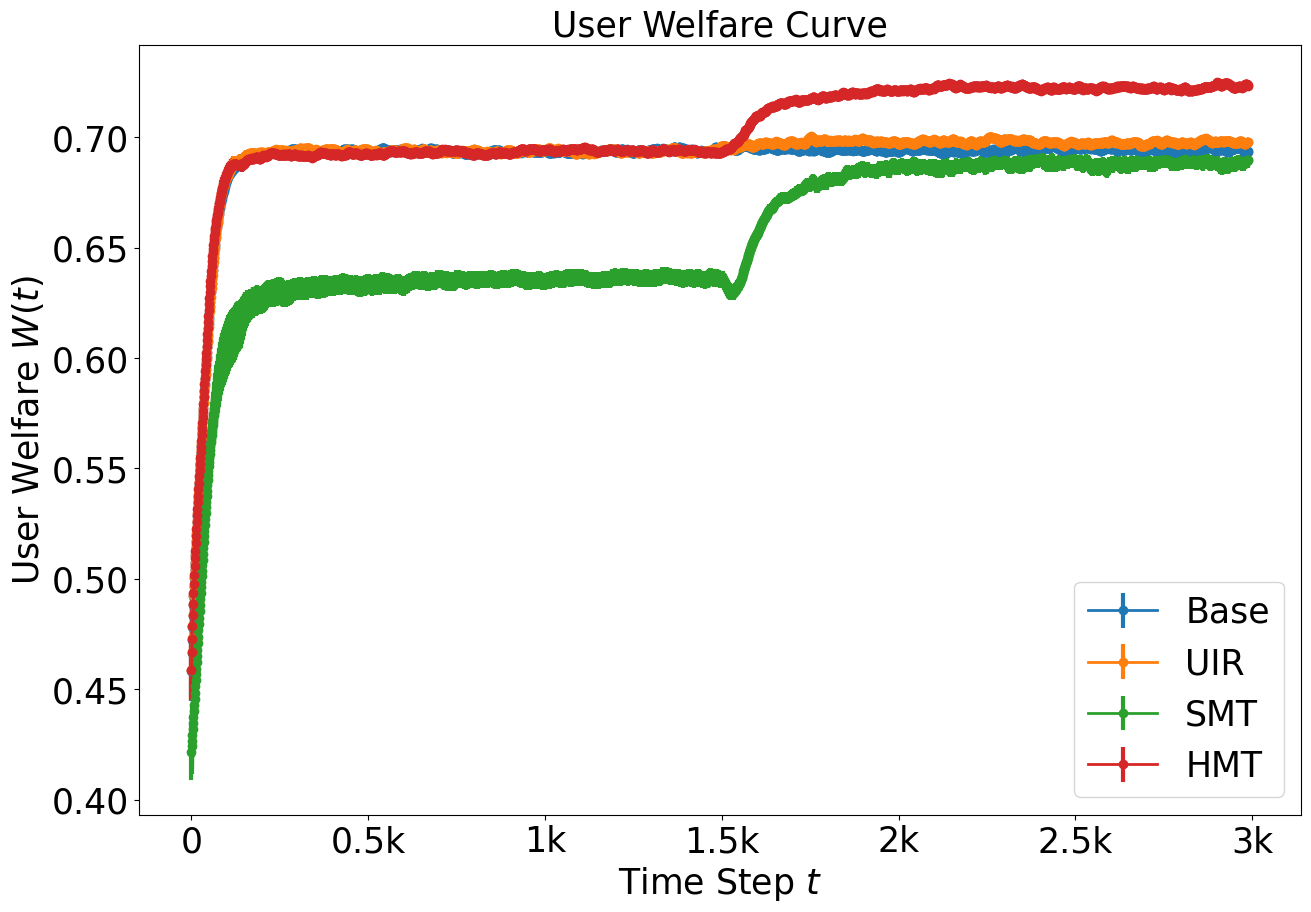

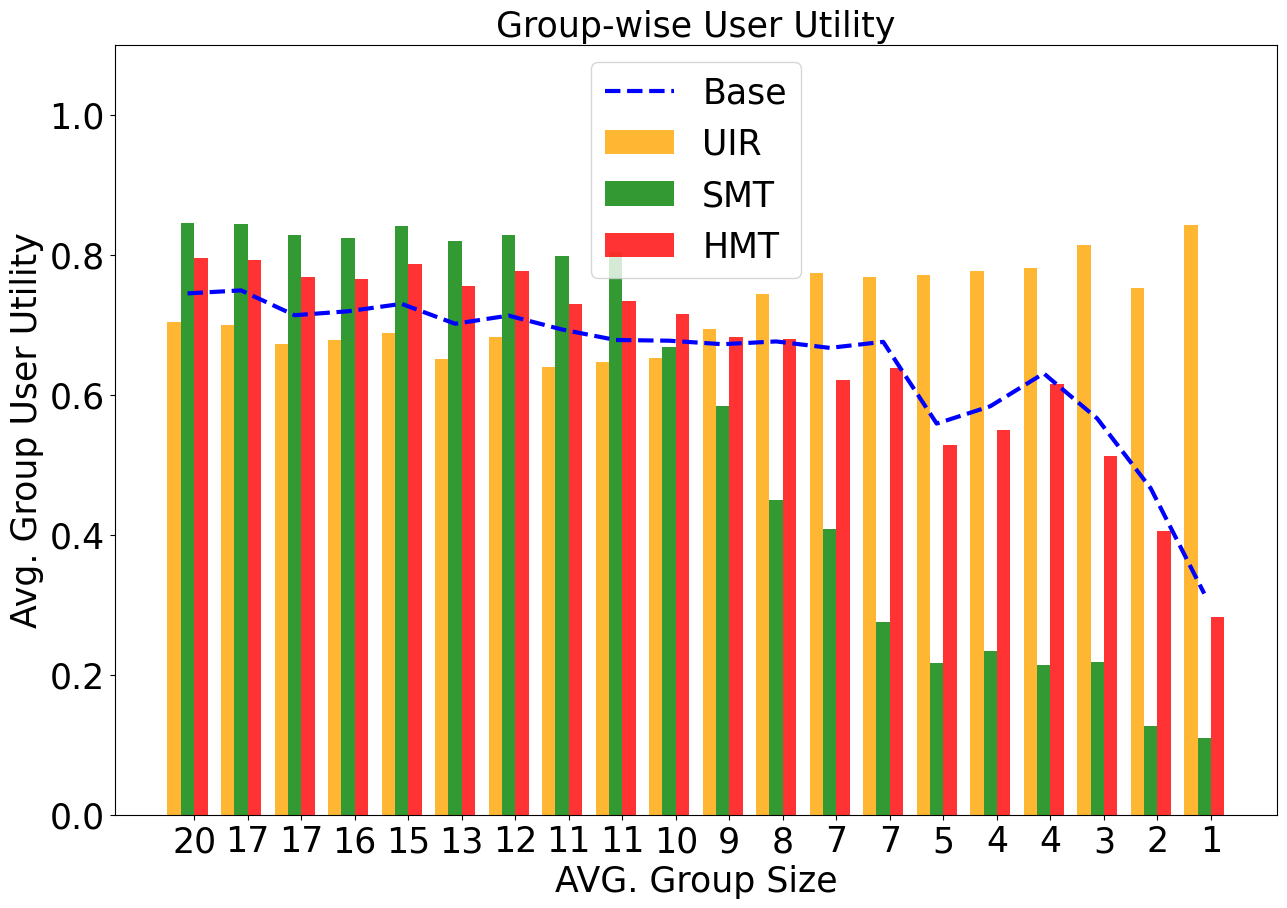

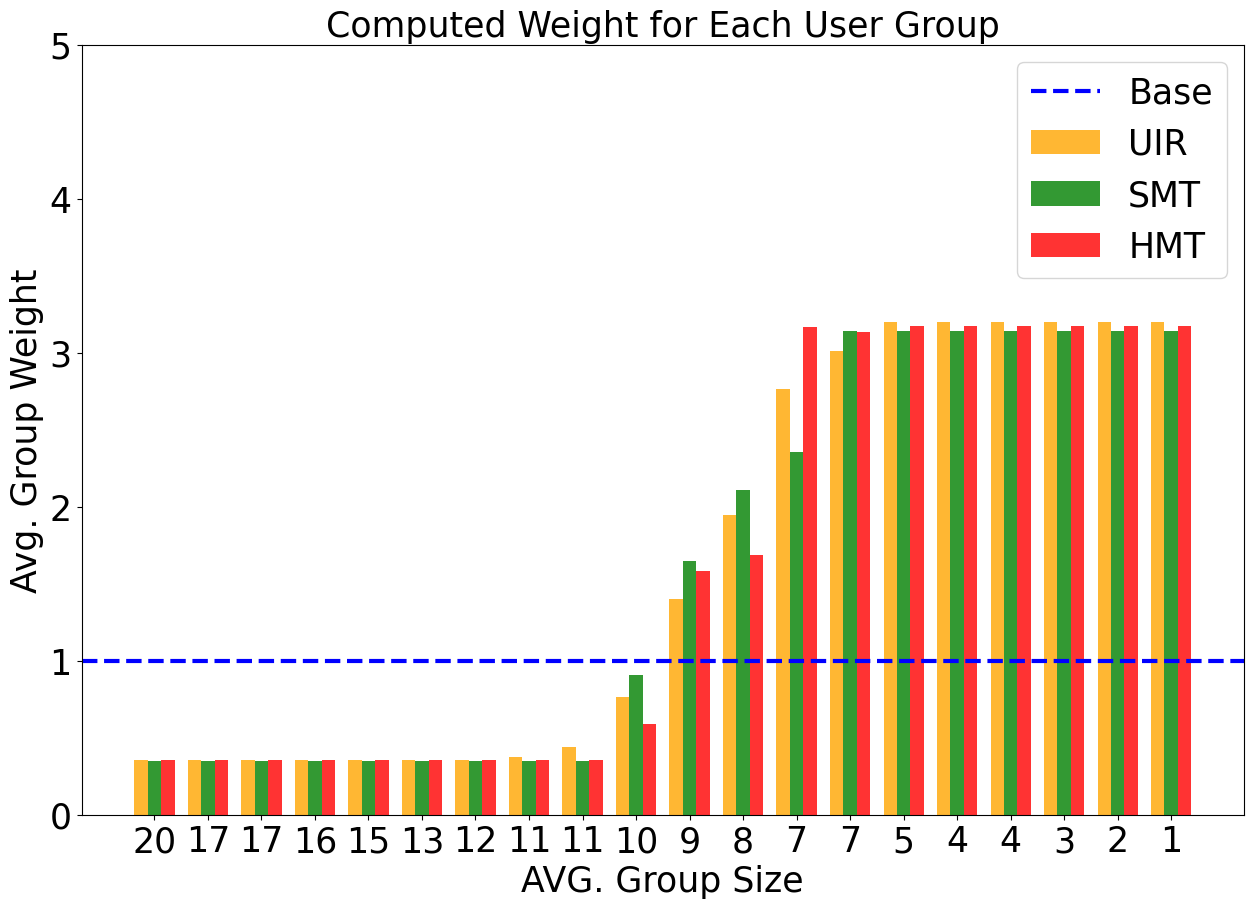

In [ ]:
# Env

np.random.seed(2)
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

## Configurations

# environment
n, d, n_clusters = 100, 5, 20            # number of players, feature dimension, number of user clusters
beta, top_k = 0.1, 20                  # user decision parameters
# utility_type = 'engagement'           # utility type of players
utility_type = 'exposure'           # utility type of players
sigma_type = 'linear_'                # the shape of relevance  score function
sigma_params = 0.1, 2
if sigma_type == 'linear':
    normalize_user_vector = True      # if True, normalize user vector to unit sphere
else:
    normalize_user_vector = False
alpha = 1.0                           # smooth constant used in relevance function

# user behavior
user_noise_type = 'Gaussian'          # user decision noise, Gaussian or Gumbel


# player behavior
action_restrict_domain = 0.0
k = None                              # the size of action set. When set to None, the action set is continuous
lr = 0.2                          # the learning rate of players
same_init = True                      # players share the same init strategy

# mechanism
mechanism = 'hard_trunc'              # "hard_trunc/soft_trunc/default" if default, directly use weight in utility
MAX_W = 3.0                           # maximum weight, used in clipping
a = 0.1                               # the rate of user weights update

# schedule
num_epoch = 600                      # length of outer loop
T = 5                                 # length of inner loop
smooth_window = 10
num_trial = 10

# dataset
stylized_data = False                  # if True, generate the 5 cluster stylized synthetic data
swift_mode = True                     # if True, do not consider tie-breaking to increase speed
user_group_sizes = [x for x in [100, 50, 20, 10, 10, 5, 2, 1, 1, 1]]
# user_group_sizes = [x for x in [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]]
m = sum(user_group_sizes)
data_set = 'movielens_'

if data_set == 'movielens':
    user_emb = pickle.load(open(data_path+'/user_emb32.pkl', mode='rb'))
    movie_emb = pickle.load(open(data_path+'/movie_emb32.pkl', mode='rb'))
    sigma_type = 'ml_linear'                                              # the shape of relevance score function
    k = 200                                                               # size of action set
    users = user_emb
    m, d = users.shape
    S = np.stack([movie_emb[np.random.choice(3883, k)] for _ in range(n)])


# np.random.seed(0)


# the results we want to collect
base_plot, UIR_plot, SMT_plot, HMT_plot = [], [], [], []
c_weight = np.zeros((num_trial, n_clusters))
c_size = np.zeros((num_trial, n_clusters))
c_avg_utility = [np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters))]
c_avg_weight = [np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters))]

for trial_number in range(num_trial):

    if data_set != 'movielens':

        # For synthetic experiment, generate new dataset for each trial
        # user_group_sizes = np.random.zipf(a=2, size=10)

        users, S, centroids = gen_user_S(n=n, k=k, d=d,
                              user_group_sizes=user_group_sizes,
                              centroid_distr='normal',
                              action_type='continuous',
                              user_cluster_radius=0.5,
                              action_cluster_radius=0.1,
                              normalization=normalize_user_vector,
                              stylized=stylized_data)



    group_labels = KMeans(n_clusters=n_clusters, random_state=0).fit(users).labels_
    cluster_labels = np.zeros((m, n_clusters))
    cluster_labels[range(m), group_labels] = 1  # (m, n_cluster)
    cluster_nums = np.sum(cluster_labels, axis=0)
    reorder = np.argsort(cluster_nums)[::-1]

    # construct the game instance
    G = Competition(score_func='sigma',
                    n_player=n,
                    users=users,
                    beta=beta,
                    alpha=alpha,
                    top_k=top_k,
                    sigma_type=sigma_type,
                    utility_type=utility_type,
                    user_noise_type=user_noise_type,
                    mechanism=mechanism,
                    sigma_params=sigma_params
                    )

    G.config_action_set(S=S)  # (n, 19, 32)

    user_weight_options = ('vanilla', 'UIR', 'SMT', 'HMT')
    adaptive = False

    avg_W_plot = []
    avg_u_plot = []
    if data_set != 'movielens':
        # init_s = centroids
        # init_s = np.stack([centroids[0]]*n)
        # init_s = np.array([[0.,0.5],[0.,0.5],[0.,0.5],[0.,0.5],[0.,0.5]])
        if not same_init:
            init_s = np.random.randn(n, d)
        else:
            init_s = np.vstack([np.random.randn(1, d)] * n)
            init_s = np.vstack([centroids[0]] * n)
        if G.scoring_rule.type == 'linear':
            init_s = normalize(init_s)
        # np.random.shuffle(init_s)
        # np.random.shuffle(init_s)
    else:
        init_s = movie_emb[np.random.choice(3883, n)]

    init_s_norm = np.linalg.norm(init_s, axis=1)

    for experiment_id in range(len(user_weight_options)):

        if user_weight_options[experiment_id] == 'UIR':
            adaptive = True
            G.mechanism = 'default'
        elif user_weight_options[experiment_id] == 'SMT':
            adaptive = True
            G.mechanism = 'soft_trunc'
        elif user_weight_options[experiment_id] == 'HMT':
            adaptive = True
            G.mechanism = 'hard_trunc'
        else:
            adaptive = False
        user_weight = np.ones(m)

        W_seq = []
        user_weight_seq = []
        r_seq_seq = []
        s_seq = []

        s = copy.copy(init_s)
        for i in tqdm(range(num_epoch)):

            if data_set == 'movielens':
                w_seq, u_seq, r_seq, W, s_end_epoch = G.run_pgd(
                    T=T, init_s=s, lr=lr,
                    restrict_domain=action_restrict_domain,
                    user_weight=user_weight)
            else:
                w_seq, u_seq, r_seq, W, s_end_epoch = G.run_gd(
                    T=T, init_s=s, lr=lr,
                    restrict_domain=action_restrict_domain,
                    user_weight=user_weight)

                # project_s = s_end_epoch * init_s_norm.reshape(n, 1) / np.linalg.norm(s_end_epoch, axis=1).reshape(n, 1)
                # allowed_update = (np.linalg.norm(s_end_epoch - init_s, axis=1) < action_restrict_domain) + 0.0
                # s += (s_end_epoch - s) * allowed_update.reshape(n, 1)
            s = s_end_epoch


            user_weight_seq.append(user_weight)
            r_seq_seq.append(sum(r_seq) / T * beta)

            # print('Empirical strategy distribution:', s)

            # print('actual W:', W, '\n')

            # append the welfare sequence for the current epoch
            W_seq += w_seq

            if adaptive and i > num_epoch/2:
                # use total group user util instead of avg. group util
                avg_user_utility_per_cluster_4_update = (sum(r_seq) / T * m) @ cluster_labels / (sum(cluster_nums)/len(cluster_nums))
                # avg_user_utility_per_cluster_4_update = (sum(r_seq) / T * m) @ cluster_labels / cluster_nums
                user_weight = user_weight * np.exp(-a*cluster_labels @ avg_user_utility_per_cluster_4_update)
                # clipping
                user_weight = np.clip(user_weight, 1./MAX_W, MAX_W)
                # normalize weight (sum=1)
                user_weight = user_weight / sum(user_weight) * len(user_weight)

        avg_user_utility_per_cluster = (sum(r_seq) / T * m) @ cluster_labels / cluster_nums
        avg_weight_per_cluster = user_weight @ cluster_labels / cluster_nums
        c_avg_utility[experiment_id][trial_number] = avg_user_utility_per_cluster[reorder]
        c_avg_weight[experiment_id][trial_number] = avg_weight_per_cluster[reorder]

        avg_W = np.array([np.mean(W_seq[i:i+smooth_window]) for i in range(len(W_seq)-smooth_window)])
        avg_W_plot.append(avg_W)
        avg_u_plot.append(sum(u_seq))

    base_plot.append( avg_W_plot[0] )
    UIR_plot.append( avg_W_plot[1] )
    SMT_plot.append(avg_W_plot[2])
    HMT_plot.append(avg_W_plot[3])

    # collect per-cluster statistics after each trial
    w = np.zeros(n_clusters)
    for i in range(n_clusters):
        w[i] = user_weight[group_labels == i][0]
    c_weight[trial_number] = w[reorder]
    c_size[trial_number] = cluster_nums[reorder]
    c_avg_utility[experiment_id][trial_number] = avg_user_utility_per_cluster[reorder]



# plot user welfare curve
plot_error_bar3(data=[base_plot, UIR_plot, SMT_plot, HMT_plot], shrink=.2)

# utility bar plot
plot_utility_bar(c_size, c_avg_utility, y_lim=(0., 1.1))

# group weight bar plot
plot_weight_bar(c_size, c_avg_weight, y_lim=(0., 5.0))




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 400/400 [00:29<00:00, 13.52it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 400/400 [00:29<00:00, 13.64it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 400/400 [00:29<00:00, 13.38it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

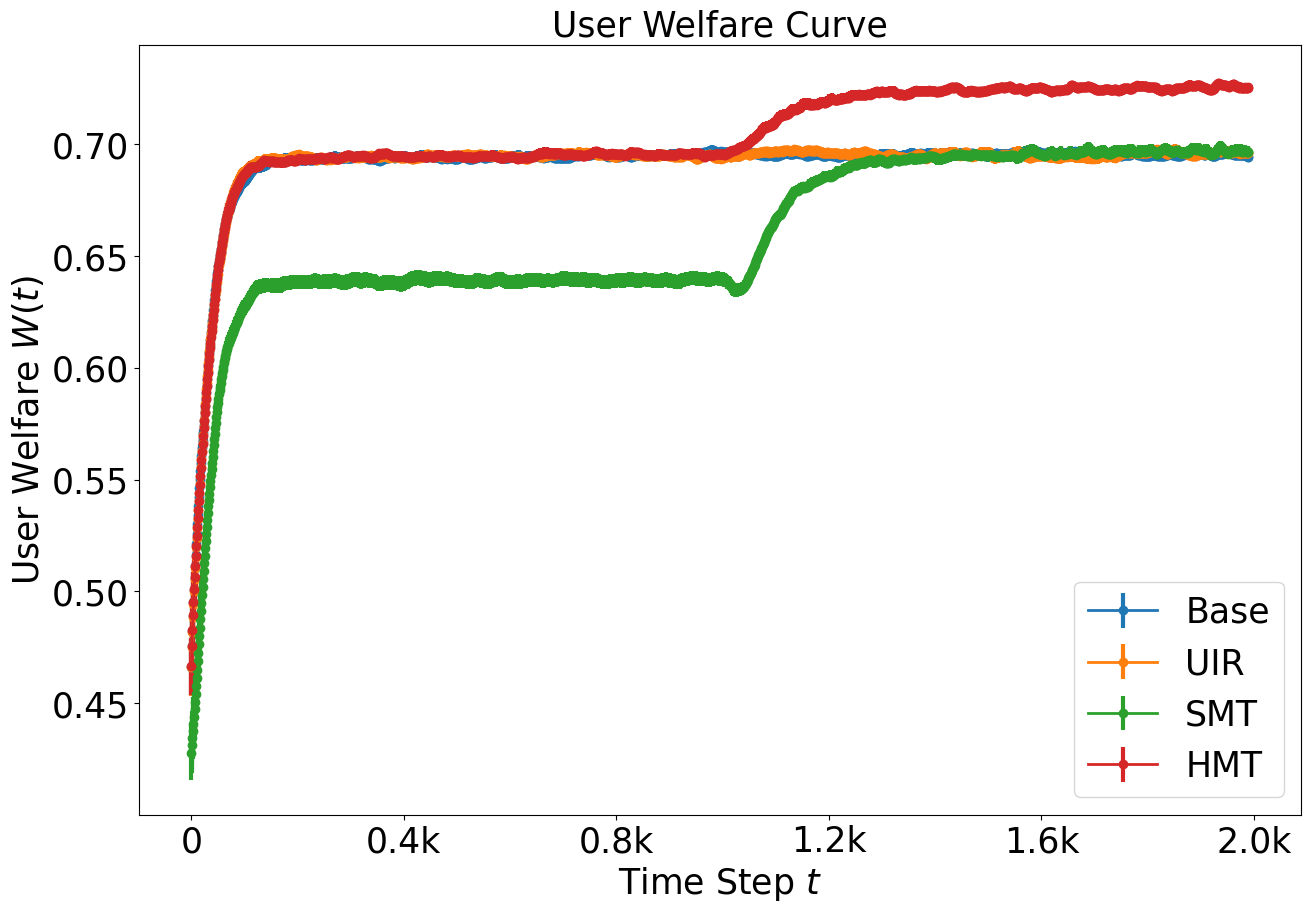

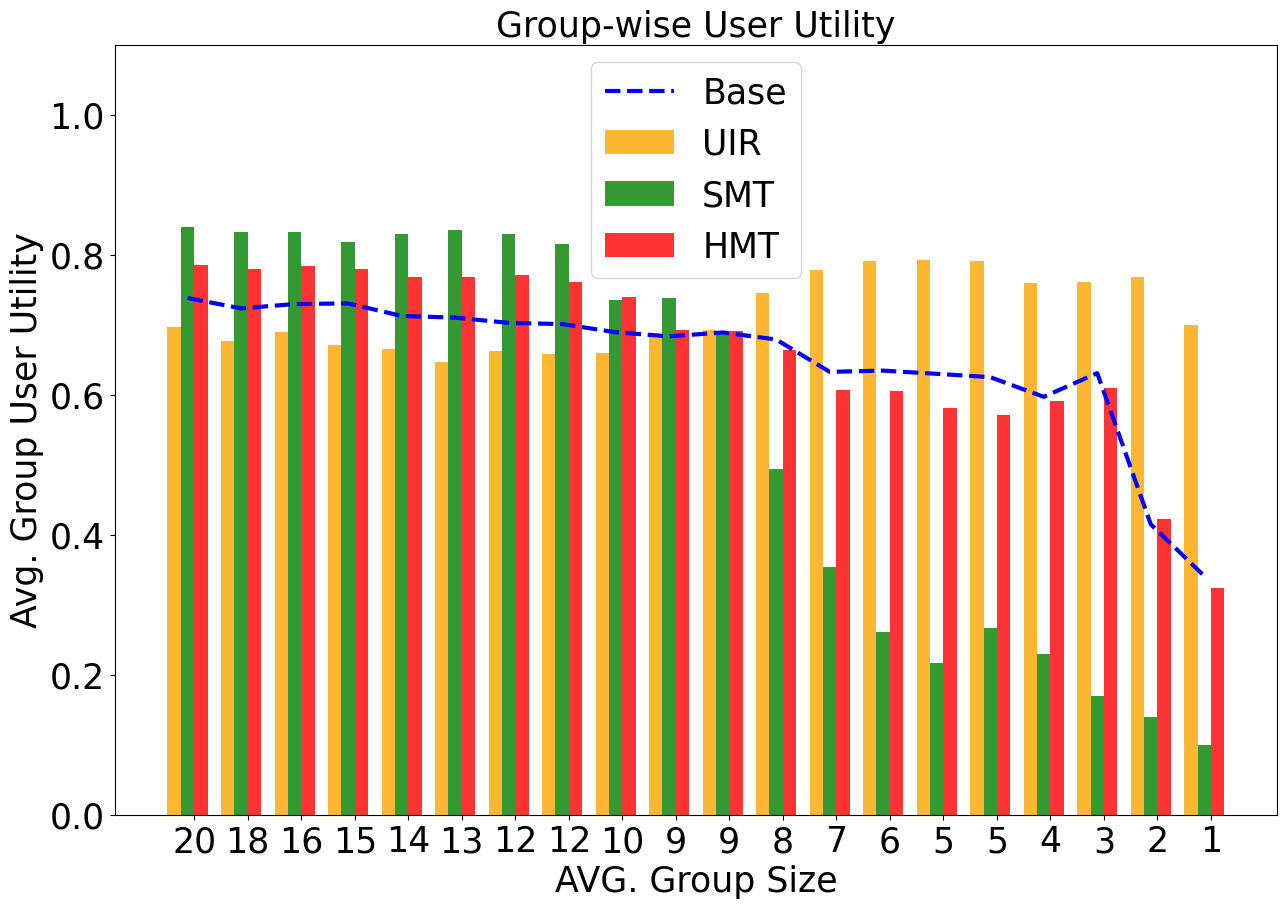

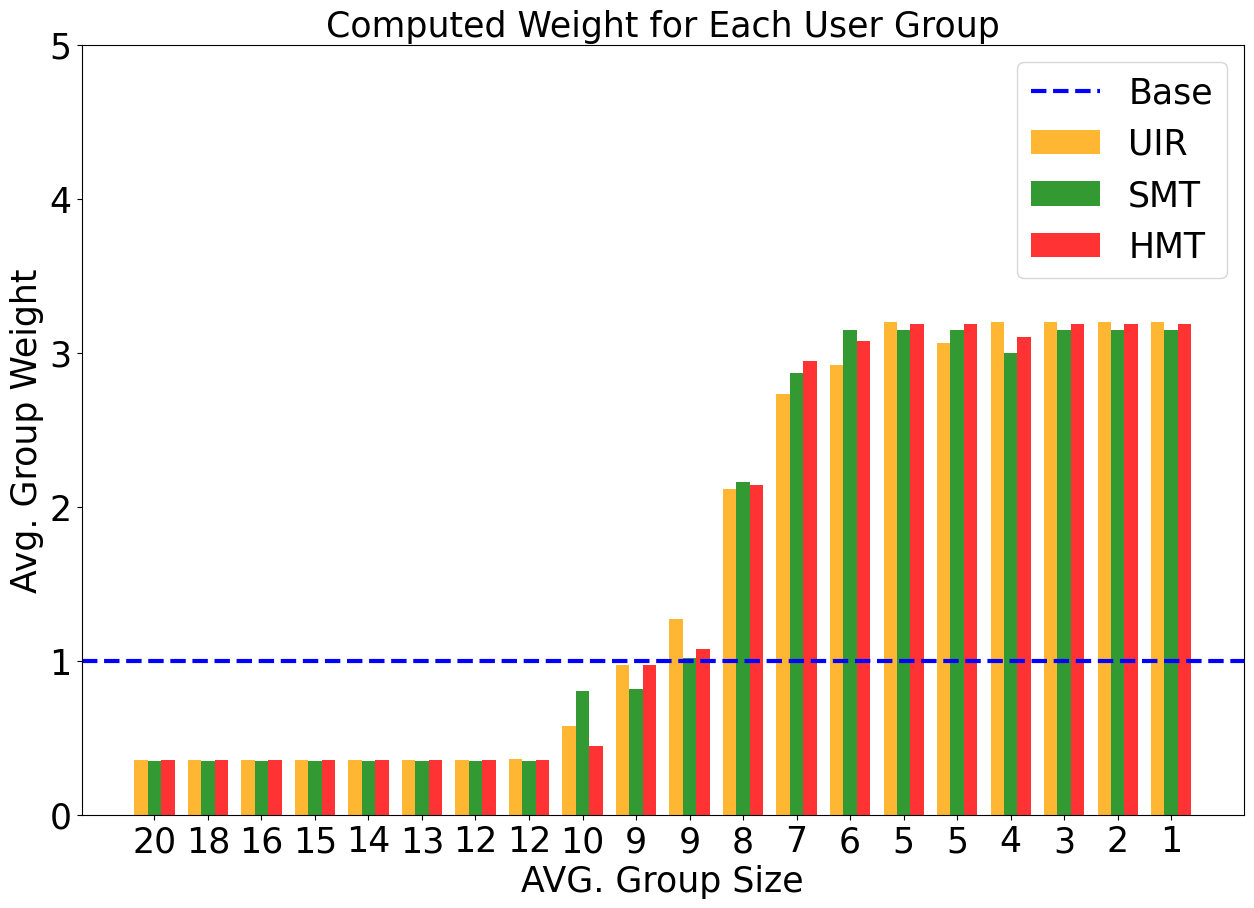

In [ ]:
# Env

np.random.seed(4)
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

## Configurations

# environment
n, d, n_clusters = 100, 5, 20            # number of players, feature dimension, number of user clusters
beta, top_k = 0.1, 20                  # user decision parameters
# utility_type = 'engagement'           # utility type of players
utility_type = 'exposure'           # utility type of players
sigma_type = 'linear_'                # the shape of relevance  score function
sigma_params = 0.1, 2
if sigma_type == 'linear':
    normalize_user_vector = True      # if True, normalize user vector to unit sphere
else:
    normalize_user_vector = False
alpha = 1.0                           # smooth constant used in relevance function

# user behavior
user_noise_type = 'Gaussian'          # user decision noise, Gaussian or Gumbel


# player behavior
action_restrict_domain = 0.0
k = None                              # the size of action set. When set to None, the action set is continuous
lr = 0.2                          # the learning rate of players
same_init = True                      # players share the same init strategy

# mechanism
mechanism = 'hard_trunc'              # "hard_trunc/soft_trunc/default" if default, directly use weight in utility
MAX_W = 3.0                           # maximum weight, used in clipping
a = 0.1                               # the rate of user weights update

# schedule
num_epoch = 400                      # length of outer loop
T = 5                                 # length of inner loop
smooth_window = 10
num_trial = 10

# dataset
stylized_data = False                  # if True, generate the 5 cluster stylized synthetic data
swift_mode = True                     # if True, do not consider tie-breaking to increase speed
user_group_sizes = [x for x in [100, 50, 20, 10, 10, 5, 2, 1,1, 1]]
# user_group_sizes = [x for x in [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]]
m = sum(user_group_sizes)
data_set = 'movielens_'

if data_set == 'movielens':
    user_emb = pickle.load(open(data_path+'/user_emb32.pkl', mode='rb'))
    movie_emb = pickle.load(open(data_path+'/movie_emb32.pkl', mode='rb'))
    sigma_type = 'ml_linear'                                              # the shape of relevance score function
    k = 200                                                               # size of action set
    users = user_emb
    m, d = users.shape
    S = np.stack([movie_emb[np.random.choice(3883, k)] for _ in range(n)])


# np.random.seed(0)


# the results we want to collect
base_plot, UIR_plot, SMT_plot, HMT_plot = [], [], [], []
c_weight = np.zeros((num_trial, n_clusters))
c_size = np.zeros((num_trial, n_clusters))
c_avg_utility = [np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters))]
c_avg_weight = [np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters)), np.zeros((num_trial, n_clusters))]

for trial_number in range(num_trial):

    if data_set != 'movielens':

        # For synthetic experiment, generate new dataset for each trial
        # user_group_sizes = np.random.zipf(a=2, size=10)

        users, S, centroids = gen_user_S(n=n, k=k, d=d,
                              user_group_sizes=user_group_sizes,
                              centroid_distr='normal',
                              action_type='continuous',
                              user_cluster_radius=0.5,
                              action_cluster_radius=0.1,
                              normalization=normalize_user_vector,
                              stylized=stylized_data)



    group_labels = KMeans(n_clusters=n_clusters, random_state=0).fit(users).labels_
    cluster_labels = np.zeros((m, n_clusters))
    cluster_labels[range(m), group_labels] = 1  # (m, n_cluster)
    cluster_nums = np.sum(cluster_labels, axis=0)
    reorder = np.argsort(cluster_nums)[::-1]

    # construct the game instance
    G = Competition(score_func='sigma',
                    n_player=n,
                    users=users,
                    beta=beta,
                    alpha=alpha,
                    top_k=top_k,
                    sigma_type=sigma_type,
                    utility_type=utility_type,
                    user_noise_type=user_noise_type,
                    mechanism=mechanism,
                    sigma_params=sigma_params
                    )

    G.config_action_set(S=S)  # (n, 19, 32)

    user_weight_options = ('vanilla', 'UIR', 'SMT', 'HMT')
    adaptive = False

    avg_W_plot = []
    avg_u_plot = []
    if data_set != 'movielens':
        # init_s = centroids
        # init_s = np.stack([centroids[0]]*n)
        # init_s = np.array([[0.,0.5],[0.,0.5],[0.,0.5],[0.,0.5],[0.,0.5]])
        if not same_init:
            init_s = np.random.randn(n, d)
        else:
            init_s = np.vstack([np.random.randn(1, d)] * n)
            init_s = np.vstack([centroids[0]] * n)
        if G.scoring_rule.type == 'linear':
            init_s = normalize(init_s)
        # np.random.shuffle(init_s)
        # np.random.shuffle(init_s)
    else:
        init_s = movie_emb[np.random.choice(3883, n)]

    init_s_norm = np.linalg.norm(init_s, axis=1)

    for experiment_id in range(len(user_weight_options)):

        if user_weight_options[experiment_id] == 'UIR':
            adaptive = True
            G.mechanism = 'default'
        elif user_weight_options[experiment_id] == 'SMT':
            adaptive = True
            G.mechanism = 'soft_trunc'
        elif user_weight_options[experiment_id] == 'HMT':
            adaptive = True
            G.mechanism = 'hard_trunc'
        else:
            adaptive = False
        user_weight = np.ones(m)

        W_seq = []
        user_weight_seq = []
        r_seq_seq = []
        poa_seq = []
        s_seq = []

        s = copy.copy(init_s)
        for i in tqdm(range(num_epoch)):

            if data_set == 'movielens':
                w_seq, u_seq, r_seq, W, s_end_epoch = G.run_pgd(
                    T=T, init_s=s, lr=lr,
                    restrict_domain=action_restrict_domain,
                    user_weight=user_weight)
            else:
                w_seq, u_seq, r_seq, W, s_end_epoch = G.run_gd(
                    T=T, init_s=s, lr=lr,
                    restrict_domain=action_restrict_domain,
                    user_weight=user_weight)

                # project_s = s_end_epoch * init_s_norm.reshape(n, 1) / np.linalg.norm(s_end_epoch, axis=1).reshape(n, 1)
                # allowed_update = (np.linalg.norm(s_end_epoch - init_s, axis=1) < action_restrict_domain) + 0.0
                # s += (s_end_epoch - s) * allowed_update.reshape(n, 1)
            s = s_end_epoch


            user_weight_seq.append(user_weight)
            r_seq_seq.append(sum(r_seq) / T * beta)

            # print('Empirical strategy distribution:', s)

            # print('actual W:', W, '\n')

            # append the welfare sequence for the current epoch
            W_seq += w_seq

            if adaptive and i > num_epoch/2:
                # use total group user util instead of avg. group util
                avg_user_utility_per_cluster_4_update = (sum(r_seq) / T * m) @ cluster_labels / (sum(cluster_nums)/len(cluster_nums))
                # avg_user_utility_per_cluster_4_update = (sum(r_seq) / T * m) @ cluster_labels / cluster_nums
                user_weight = user_weight * np.exp(-a*cluster_labels @ avg_user_utility_per_cluster_4_update)
                # clipping
                user_weight = np.clip(user_weight, 1./MAX_W, MAX_W)
                # normalize weight (sum=1)
                user_weight = user_weight / sum(user_weight) * len(user_weight)

        avg_user_utility_per_cluster = (sum(r_seq) / T * m) @ cluster_labels / cluster_nums
        avg_weight_per_cluster = user_weight @ cluster_labels / cluster_nums
        c_avg_utility[experiment_id][trial_number] = avg_user_utility_per_cluster[reorder]
        c_avg_weight[experiment_id][trial_number] = avg_weight_per_cluster[reorder]

        avg_W = np.array([np.mean(W_seq[i:i+smooth_window]) for i in range(len(W_seq)-smooth_window)])
        avg_W_plot.append(avg_W)
        avg_u_plot.append(sum(u_seq))

    base_plot.append( avg_W_plot[0] )
    UIR_plot.append( avg_W_plot[1] )
    SMT_plot.append(avg_W_plot[2])
    HMT_plot.append(avg_W_plot[3])

    # collect per-cluster statistics after each trial
    w = np.zeros(n_clusters)
    for i in range(n_clusters):
        w[i] = user_weight[group_labels == i][0]
    c_weight[trial_number] = w[reorder]
    c_size[trial_number] = cluster_nums[reorder]
    c_avg_utility[experiment_id][trial_number] = avg_user_utility_per_cluster[reorder]



# plot user welfare curve
plot_error_bar3(data=[base_plot, UIR_plot, SMT_plot, HMT_plot], shrink=.2)

# utility bar plot
plot_utility_bar(c_size, c_avg_utility, y_lim=(0., 1.1))

# group weight bar plot
plot_weight_bar(c_size, c_avg_weight, y_lim=(0., 5.0))


